## Velocity of hopping events

## Saving as CSV file

In [1]:
import pandas as pd
import numpy as np
from tkinter import filedialog
from tkinter import Tk
import os

In [2]:
# Hide Tkinter root window
root = Tk()
root.withdraw()

# Open file dialog to select multiple CSV files
file_paths = filedialog.askopenfilenames(title="Select CSV files", filetypes=[("CSV files", "*.csv")])


In [3]:
all_data = []
file_names = []

for file_path in file_paths:
    data = pd.read_csv(file_path)
    data['source_file'] = os.path.basename(file_path) # Add a column to keep track of the file source
    all_data.append(data)

# Concatenate all data
data = pd.concat(all_data, ignore_index=True)

# Convert step_flag column to boolean
data['step_flag'] = data['step_flag'].astype(str).str.upper() == 'TRUE'

# Initialize lists to store total distance, total time, source files, track IDs, and velocities
total_displacements = []
total_times = []
velocities = []
source_files = []
track_ids = []

# Find sequences of consecutive TRUE values
current_distance = 0
current_time = 0
previous_flag = False
current_source_file = None
current_track_id = None

for i, row in data.iterrows():
    if row['step_flag']:
        if not previous_flag:
            # Capture current file source and track ID when we see the start of a sequence of TRUE
            current_source_file = row['source_file']
            current_track_id = row['trackID']
        current_distance += row['step_sizes'] * 0.117  # Convert pixels to micrometers (um)
        current_time += 2  # Convert frame to seconds
        previous_flag = True
    else:
        if previous_flag:
            total_displacements.append(current_distance)
            total_times.append(current_time)
            source_files.append(current_source_file)
            track_ids.append(current_track_id)
            if current_time > 0:
                velocities.append(current_distance / current_time)
            current_distance = 0
            current_time = 0
            previous_flag = False

# Edge case: if the data ends with a sequence of TRUE values
if previous_flag:
    total_displacements.append(current_distance)
    total_times.append(current_time)
    source_files.append(current_source_file)
    track_ids.append(current_track_id)
    if current_time > 0:
        velocities.append(current_distance / current_time)

# Convert the collected data into a DataFrame
velocity_data = pd.DataFrame({
    'source_file': source_files,
    'trackID': track_ids,
    'displacement': total_displacements,
    'time': total_times,
    'velocity': velocities
})

# Get directory to save the output CSV
if file_paths:
    output_dir = os.path.dirname(file_paths[0])
else:
    output_dir = '.'

output_path = os.path.join(output_dir, 'velocity_data_hopping_events.csv')
velocity_data.to_csv(output_path, index=False)

print(f"Velocity data saved to {output_path}")

Velocity data saved to Z:/Bisal_Halder_turbo/PROCESSED_DATA/Impact_of_cytoskeleton_on_HOPS_condensates/HOPS_Microtubule_dual imaging_SiR_Tubulin/Analysed data/For_montage\velocity_data_hopping_events.csv


## Plotting the velocity distribution

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the velocity data CSV file
file_path = r"Z:\Bisal_Halder_turbo\PROCESSED_DATA\Impact_of_cytoskeleton_on_HOPS_condensates\no_drug\Analysed Data\2x\Trackmate analysis new 07052024\flagged_tracks_w20\velocity_data_hopping_events.csv"
velocity_data = pd.read_csv(file_path)

In [3]:
# Calculate and print mean velocity
mean_velocity = velocity_data['velocity'].mean()
print(f"Mean velocity: {mean_velocity:.4f} μm/s")

Mean velocity: 0.2992 μm/s


In [7]:
# --- Find the peak (mode) of the histogram ---
counts, bin_edges = np.histogram(velocity_data['velocity'], bins=10, range=(0, 0.6))
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Get center of each bin
peak_bin_index = np.argmax(counts)  # Index of the bin with the highest count
peak_velocity = bin_centers[peak_bin_index]  # Velocity at the peak bin

print(f"Peak velocity (histogram mode): {peak_velocity:.4f} μm/s")

Peak velocity (histogram mode): 0.2100 μm/s


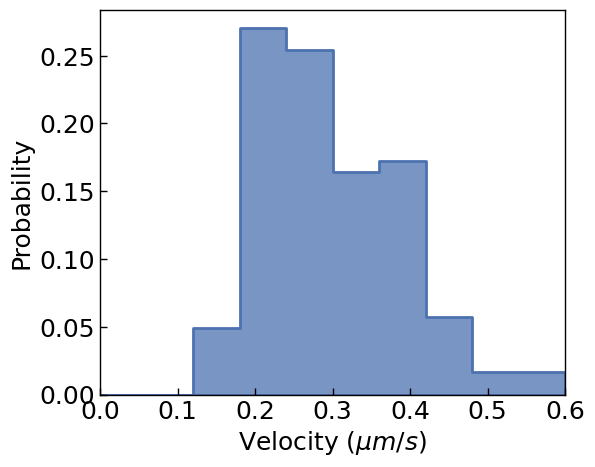

In [11]:
# Plot configuration
plt.figure(figsize=(6, 5))

# Create the plot
ax = sns.histplot(
    data=velocity_data,
    x="velocity",
    bins=10,
    binrange=(0, 0.6),
    stat="probability",
    common_norm=False,
    lw=2,
    element="step",
    legend=False,
    color="#4C72B0"
)

# Example usage of vertical line and text
# plt.axvline(0.5, ls="--", c="gray", lw=2)
# plt.text(0.52, 0.078, f"N$_{{steps}}$ = {len(velocity_data):,}", fontdict={"fontsize": 16})

plt.xlim(0, 0.6)
plt.ylim(0, None)
plt.xlabel(r"Velocity ($\mu m/s$)", fontsize=18)
plt.ylabel("Probability", fontsize=18)
plt.gca().spines[:].set_linewidth(1)
plt.gca().tick_params(
    axis="both",
    which="major",
    labelsize=18,
    direction="in",
    bottom=True,
    left=True,
    length=5,
    width=1,
)
plt.gca().set_axisbelow(False)
plt.savefig("velocity_distribution.png", format="png", bbox_inches="tight", dpi=600)
plt.show()

## Plotting the velocity distribution with fitting line

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm


In [2]:
# Load the velocity data CSV file
file_path = r"Z:\Bisal_Halder_turbo\PROCESSED_DATA\Impact_of_cytoskeleton_on_HOPS_condensates\no_drug\Analysed Data\2x\Trackmate analysis new 07052024\flagged_tracks_w20\velocity_data_hopping_events.csv"
velocity_data = pd.read_csv(file_path)

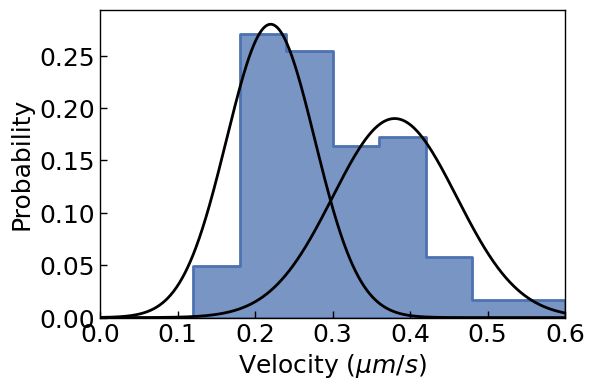

In [13]:
# Plot configuration
plt.figure(figsize=(6, 4))

# Create the histogram plot
ax = sns.histplot(
    data=velocity_data,
    x="velocity",
    bins=10,
    binrange=(0, 0.6),
    stat="probability",
    lw=2,
    element="step",
    legend=False,
    color="#4C72B0"
)

# Define Gaussian parameters
peak1_x = 0.22
peak2_x = 0.38

# Adjust standard deviations to better fit the data
std1 = 0.057  # Adjust this value as needed
std2 = 0.08  # Adjust this value as needed

# Create Gaussian curves using estimated peaks based on histogram
x_values = np.linspace(0, 0.6, 1000)
gaussian1 = norm.pdf(x_values, peak1_x, std1)
gaussian2 = norm.pdf(x_values, peak2_x, std2)

# Scale Gaussians to match the histogram's peak heights
scale1 = 0.28 / gaussian1.max()
scale2 = 0.19 / gaussian2.max()

# Plot Gaussian curves
plt.plot(x_values, gaussian1 * scale1, c='black', lw=2)
plt.plot(x_values, gaussian2 * scale2, c='black', lw=2)

plt.xlim(0, 0.6)
plt.ylim(0, None)
plt.xlabel(r"Velocity ($\mu m/s$)", fontsize=18)
plt.ylabel("Probability", fontsize=18)
plt.gca().spines[:].set_linewidth(1)
plt.gca().tick_params(
    axis="both",
    which="major",
    labelsize=18,
    direction="in",
    bottom=True,
    left=True,
    length=5,
    width=1,
)
plt.gca().set_axisbelow(False)
# plt.legend(['Gaussian 1', 'Gaussian 2'])
plt.savefig("velocity_distribution_with_gaussians.png", format="png", bbox_inches="tight", dpi=600)
plt.show()

## velocity_of_the_consecutive_steps

In [8]:
import pandas as pd
import numpy as np
from tkinter import filedialog
from tkinter import Tk
import os

# Hide Tkinter root window
root = Tk()
root.withdraw()

# Select CSV files
file_paths = filedialog.askopenfilenames(title="Select CSV files", filetypes=[("CSV files", "*.csv")])

# Read and combine files
all_data = []
for file_path in file_paths:
    df = pd.read_csv(file_path)
    df['source_file'] = os.path.basename(file_path)
    all_data.append(df)
data = pd.concat(all_data, ignore_index=True)

# Convert step_flag to boolean
data['step_flag'] = data['step_flag'].astype(str).str.upper() == 'TRUE'

# Initialize velocity columns
data['velocity_before'] = np.nan
data['velocity_during'] = np.nan
data['velocity_after'] = np.nan

# Find all TRUE positions
true_indices = data.index[data['step_flag']]

# Calculate velocity DURING TRUE steps (individual steps)
data.loc[true_indices, 'velocity_during'] = (data.loc[true_indices, 'step_sizes'] * 0.117) / 2

if len(true_indices) > 0:
    first_true = true_indices[0]
    last_true = true_indices[-1]
    
    # BEFORE first TRUE: average of all steps before first TRUE
    if first_true > 0:
        before_steps = data.iloc[:first_true]
        total_disp = before_steps['step_sizes'].sum() * 0.117
        total_time = len(before_steps) * 2
        avg_velocity = total_disp / total_time
        data.loc[before_steps.index, 'velocity_before'] = avg_velocity
    
    # AFTER last TRUE: average of all steps after last TRUE
    if last_true < len(data) - 1:
        after_steps = data.iloc[last_true+1:]
        total_disp = after_steps['step_sizes'].sum() * 0.117
        total_time = len(after_steps) * 2
        avg_velocity = total_disp / total_time
        data.loc[after_steps.index, 'velocity_after'] = avg_velocity

# Save results
output_path = os.path.join(os.path.dirname(file_paths[0]), 'velocity_states.csv') if file_paths else 'velocity_phases.csv'
data.to_csv(output_path, index=False)

print(f"Data with phase velocities saved to {output_path}")

Data with phase velocities saved to Z:/Bisal_Halder_turbo/PROCESSED_DATA/Impact_of_cytoskeleton_on_HOPS_condensates/HOPS_Microtubule_dual imaging_SiR_Tubulin/Analysed data/For_montage\velocity_states.csv
